In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = wobble.Data('hip54287_e2ds.hdf5', filepath='data/', orders=[56])

In [3]:
model = wobble.Model(data)
model.add_star('hip54287b')
model.add_telluric('tellurics')
print(model)

Model consisting of the following components: ['hip54287b', 'tellurics']


Inject some noise & try to get back to the pipeline values by optimizing:

In [4]:
import tensorflow as tf
session = wobble.get_session()
session.run(tf.global_variables_initializer())
pipeline_rvs = session.run(model.components[0].rvs_block[0])
model.components[0].rvs_block[0].load(pipeline_rvs + np.random.normal(0., 100., data.N), session)

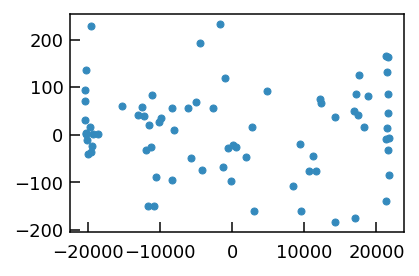

In [5]:
star_rvs = session.run(model.components[0].rvs_block[0])
initial_rvs = np.copy(star_rvs)
plt.scatter(data.pipeline_rvs, star_rvs - data.pipeline_rvs)

(4680, 4684)

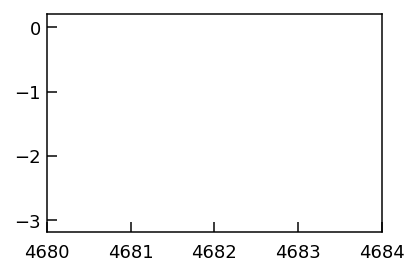

In [6]:
plt.plot(np.exp(session.run(data.xs[0][0,:])), session.run(data.ys[0][0,:]))
plt.plot(np.exp(session.run(data.xs[0][5,:])), session.run(data.ys[0][5,:]))
plt.xlim([4680, 4684])

In [7]:
for c in model.components:
    c.initialize_model(0, data)
    session.run(tf.variables_initializer([c.model_xs[0], c.model_ys[0]]))

initializing star model...
initializing tellurics model...


(4680, 4684)

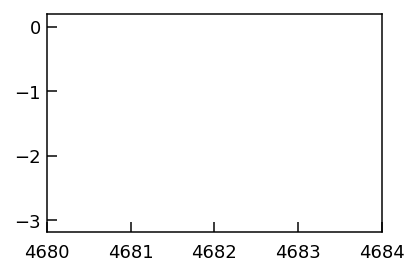

In [8]:
r=0
for c in [model.components[0]]:
    synth = c.shift_and_interp(r, data.xs[r], c.rvs_block[r])
plt.plot(np.exp(session.run(data.xs[0][0,:])), session.run(data.ys[0][0,:]))
plt.plot(np.exp(session.run(data.xs[0][0,:])), session.run(synth[0,:]))
plt.xlim([4680, 4684])

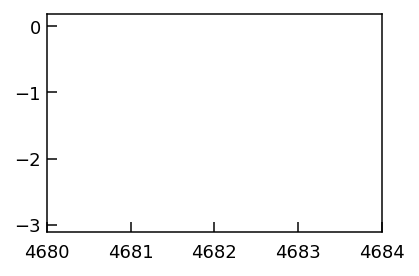

In [9]:
for c in model.components:
    model_xs = session.run(c.model_xs[0])
    model_ys = session.run(c.model_ys[0])
    plt.plot(np.exp(model_xs), model_ys)
    plt.xlim([4680, 4684])

In [10]:
%%time
niter = 100
nll_history, rvs_history, model_history, chis_history = wobble.optimize_order(model, data, 0, niter=niter, output_history=True)

  0%|          | 0/100 [00:00<?, ?it/s]

--- ORDER 0 ---


100%|██████████| 100/100 [00:11<00:00,  8.89it/s]

CPU times: user 27.7 s, sys: 3.15 s, total: 30.8 s
Wall time: 13 s


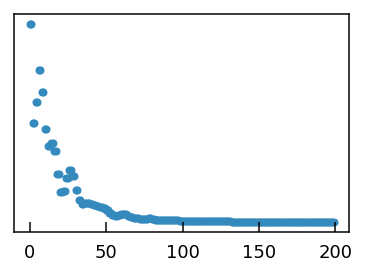

In [11]:
plt.scatter(np.arange(len(nll_history)), nll_history)
ax = plt.gca()
ax.set_yscale('log')

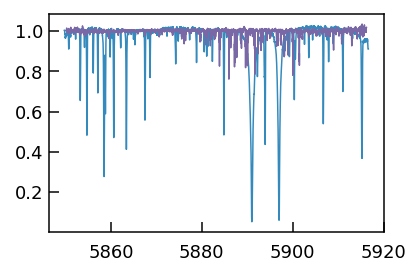

In [12]:
for c in model.components:
    model_xs = session.run(c.model_xs[0])
    model_ys = session.run(c.model_ys[0])
    plt.plot(np.exp(model_xs), np.exp(model_ys))

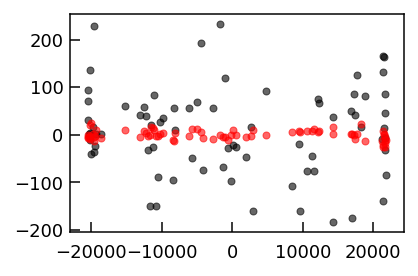

In [13]:
star_rvs = session.run(model.components[0].rvs_block[0])
plt.scatter(data.pipeline_rvs, initial_rvs - data.pipeline_rvs, color='k', alpha=0.6)
plt.scatter(data.pipeline_rvs, star_rvs - data.pipeline_rvs, color='r', alpha=0.6)

In [14]:
from IPython.display import HTML
ani = wobble.plot_rv_history(data, rvs_history, niter, niter, ylims=[-300, 300])
HTML(ani.to_html5_video())

In [ ]:
#model_xs = session.run(model.components[0].model_xs[0])
#ani = wobble.plot_model_history(model_xs, model_history, niter, 50)
data_xs = session.run(data.xs[0])
ani = wobble.plot_chis_history(0, data_xs, chis_history, niter, 50, ylims=(-1.e2, 1.e2))
HTML(ani.to_html5_video())

Gradient checks:

In [ ]:
tf_grad = session.run(model.components[0].gradients_rvs)[0]

In [ ]:
r = 0
rvs = tf.placeholder(tf.float64, (75,))
synth = model.components[1].shift_and_interp(r, data.xs[r], model.components[1].rvs_block[r])
synth += model.components[0].shift_and_interp(r, data.xs[r], rvs)
nll = 0.5*tf.reduce_sum(tf.square(data.ys[r] - synth) * data.ivars[r])

In [ ]:
num_grads = np.zeros_like(tf_grad)
rvs0 = session.run(model.components[0].rvs_block[0])
nll_0 = session.run(nll, feed_dict={rvs:rvs0})
d_rvs = 0.001
for n in range(75):
    rvs1 = np.copy(rvs0)
    rvs1[n] += d_rvs
    nll_1 = session.run(nll, feed_dict={rvs:rvs1})
    num_grads[n] = np.copy((nll_1 - nll_0)/d_rvs)
print("Fractional difference between numerical gradients & TF gradient at each RV_star:")
print((num_grads - tf_grad) / np.median(np.abs(tf_grad)))

In [ ]:
from wobble.interp import interp
model_len = 6815

model_ys = tf.placeholder(tf.float64, (model_len,))
shifted_xs = data.xs[r] + tf.log(wobble.doppler((model.components[0].rvs_block[r])[:, None]))
synth = interp(shifted_xs, model.components[0].model_xs[r], model_ys) 
synth += model.components[1].shift_and_interp(r, data.xs[r], model.components[1].rvs_block[r])
nll = 0.5*tf.reduce_sum(tf.square(data.ys[r] - synth) * data.ivars[r])

In [ ]:
tf_grad = session.run(model.components[0].gradients_model)[0]
dense_grad = np.zeros(model_len)
for i in range(model_len):
    dense_grad[i] = np.sum(tf_grad.values[tf_grad.indices == i])

In [ ]:
model0 = session.run(model.components[0].model_ys[0])
nll_0 = session.run(nll, feed_dict={model_ys:model0})
d_model = 0.001
diff = []
for n in np.random.randint(0, model_len, size=20):
    model1 = np.copy(model0)
    model1[n] += d_model
    nll_1 = session.run(nll, feed_dict={model_ys:model1})
    diff.append((nll_1 - nll_0)/d_rvs - dense_grad[n])
print("Fractional difference between numerical gradients & TF gradient for random model pixels:")
print(diff / np.median(np.abs(dense_grad)))

In [ ]:
plt.plot(dense_grad)

In [ ]:
model.components[0].model_ys